# **Classifying Cancer Subtypes based on Histopathological Images**
### For GME Hackathon 2025

In this notebook, we demonstrate how to create a convolutional neural network (CNN) which can classify lung cancer into three categories based on histopathological images. This is not one of the tutorials, however it should provide a strong example for using CNNs in your own work.

As a note, all credit goes to the author of [this article](https://www.geeksforgeeks.org/lung-cancer-detection-using-convolutional-neural-network-cnn/), which provides most of the code used in this notebook.

First, we have to import the necessary packages (should already be included in the Conda environment we created for the Hackathon)

In [1]:
#Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

## set a random seed to make reproducible model
keras.utils.set_random_seed(4711)

2025-06-18 10:08:42.820773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we have to download the data. To run this correctly, **replace the word "root" in the command below with whatever folder you want to save the data to!** Alternatively, you can download the data directly from [this link](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/data?select=lung_colon_image_set).

In [2]:
#Download data
# !curl -L -o /root/lung-and-colon-cancer-histopathological-images.zip\
#  https://www.kaggle.com/api/v1/datasets/download/andrewmvd/lung-and-colon-cancer-histopathological-images

Next, we have to extract the data. Just make sure the "data_path" variable points to where you saved the file in the previous step!

In [ ]:
# data_path = '/root/lung-and-colon-cancer-histopathological-images.zip'
# data_path = '/Users/lijinghui/Downloads/lung_colon_image_set'
# with ZipFile(data_path,'r') as zip:
#  zip.extractall()
#  print('The data set has been extracted.')

Now that we've downloaded our data, let's take a look at some of the images! Just make sure that "path" points to where you have the lung image data saved!

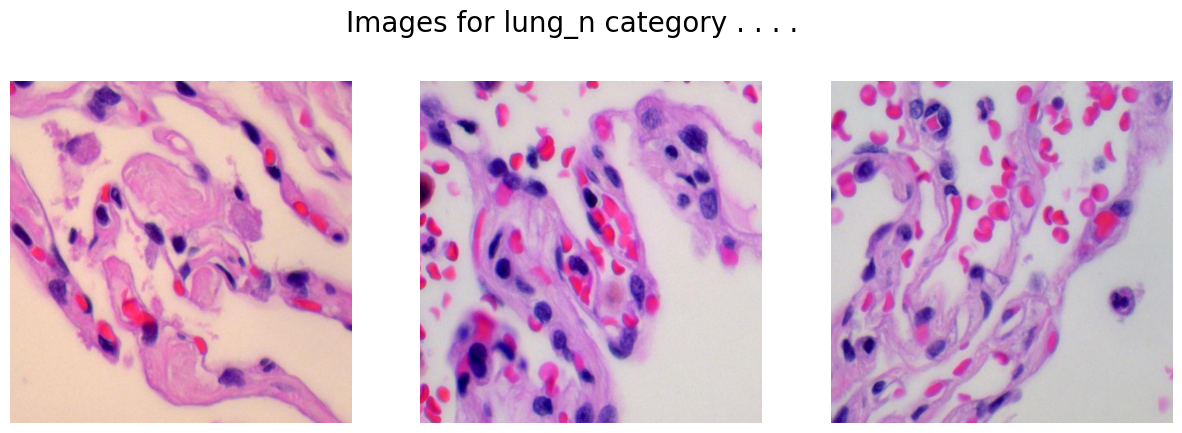

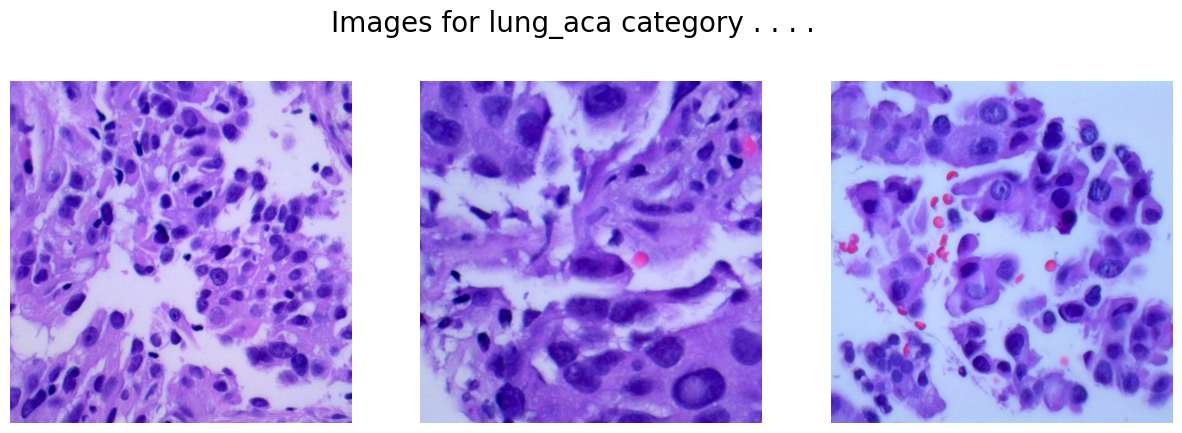

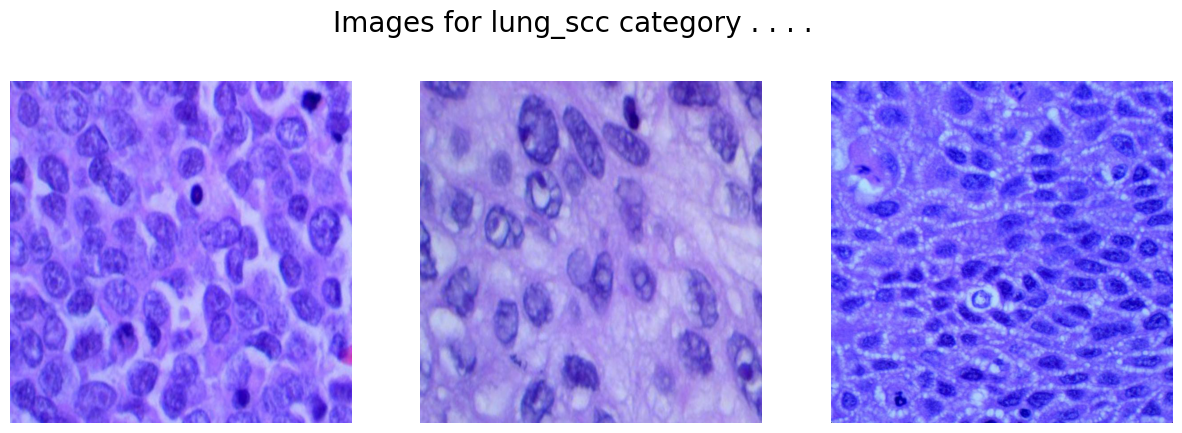

In [2]:
path = '/Users/lijinghui/Downloads/lung_colon_image_set/lung_image_sets'

classes = ['lung_n', 'lung_aca', 'lung_scc']

for cat in classes:
    image_dir = f'{path}/{cat}'
    # images = os.listdir(image_dir)
    images = glob(f"{image_dir}/lung*.jpeg")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        # img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        img = np.array(Image.open(images[k]))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

Now, to our eyes, it's pretty clear that the images for these different subtypes are pretty different! But how can we teach a computer this? First, we need to put these images into a format that the computer to analyze easily.

We take three major steps in the next block:


1.   Read each image into a computer-readable format (a NumPy array) and resize them so they are a consistent size
2.   Store the type of cancer corresponding to each image
3.   Split our data into training and testing



In [3]:
# IMG_SIZE = 256
IMG_SIZE = 128
SPLIT = 0.2
EPOCHS = 5
# BATCH_SIZE = 64
BATCH_SIZE = 8

X = [] #Empty lists where we're going to store our data
Y = [] #Empty lists where we're going to store the classification label

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg') #Identify all of the images in our folder
  print(f'Found {len(images)} {cat} images.')

  # for image in images[0:1000]: #Look at only 1000 images rather than 5000 (shortens training time, can increase if you want!)
  for image in images[0:1000]: #Look at only 1000 images rather than 5000
    img = cv2.imread(image) #Reads an image into a NumPy array

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE))) #Resize the image to be 256x256, and add to our list for X
    Y.append(i)

X = np.asarray(X) #Take our full list and recast it as NumPy array
one_hot_encoded_Y = pd.get_dummies(Y).values #Assign each of our images to a class

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022) #Split our data into train and test

Found 5000 lung_n images.
Found 5000 lung_aca images.
Found 5000 lung_scc images.


### Defining the model

Now that we have our data set up, we need to create our model! I will give a brief description of what each type of layer defined here does, but feel free to mess around with different architectures to see how well they work!



*   **Sequential**: Defines a set of neural network layers that will be executed in order.
*   **Conv2D**: A convolutional layer. This basically passes a filter over the image to consolidate information. This should be discussed in Tutorial 2, but I will put a brief description below as well.
*   **MaxPooling2D**: Further consolidates the information in the image by just taking the maximum value in each 2x2 square of a data matrix (i.e. the result from a Conv2D layer).
*   **Flatten**: Turns a 2D matrix into a 1D vector
*   **Dense**: A fully-connected layer (i.e. a standard neural network layer, which takes in a vector of one size and outputs another of a different size (usually smaller))
*   **BatchNormalization**: Not super important for our purposes, basically normalizes feature set to speed up training
*   **Dropout**: Randomly drops some neurons in order to avoid overfitting



In [4]:
model = keras.models.Sequential([
    # layers.Conv2D(filters=32,
    layers.Conv2D(filters=16,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    #layers.MaxPooling2D(2, 2),
    layers.MaxPooling2D(4, 4),

    # layers.Conv2D(filters=64,
    layers.Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    # layers.Conv2D(filters=128,
    #               kernel_size=(3, 3),
    #               activation='relu',
    #               padding='same'),
    # layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    #layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    #layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,779 (4.06 MB)

 Trainable params: 1,063,395 (4.06 MB)

 Non-trainable params: 384 (1.50 KB)

Great! Now that we've defined our model, we need to set up some parameters for training. I won't spend much time on these, but basically these will stop our training if either of the below conditions are met:


1.   Accuracy on the held-out validation set reaches greater than 90%
2.   Accuracy on held-out validation set does not improve for 3 epochs in a row

Finally, we compile our model (a necessary step to begin training for Keras).



In [5]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if logs.get('val_accuracy') > 0.90:
          print('\n Validation accuracy has reached upto \
                    90% so, stopping further training.')
          self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   mode='max',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [6]:
#If you're running into memory issues, run this block
import gc
gc.collect()
del X, one_hot_encoded_Y
gc.collect()

0

### Training the model

Finally, let's train our model! The code block below should run this automatically, and output some interesting statistics for each epoch (i.e. each run through the entire training dataset)

In [7]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    # epochs = EPOCHS,
                    epochs = 15,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6930 - loss: 0.7113 - val_accuracy: 0.3750 - val_loss: 2.8761 - learning_rate: 0.0010
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.7924 - loss: 0.5088 - val_accuracy: 0.3467 - val_loss: 9.3205 - learning_rate: 0.0010
Epoch 3/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8006 - loss: 0.4733
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8006 - loss: 0.4734 - val_accuracy: 0.3450 - val_loss: 7.4026 - learning_rate: 0.0010
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8392 - loss: 0.3985 - val_accuracy: 0.8450 - val_loss: 0.3780 - learning_rate: 5.0000e-04
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8645 - loss: 0.3444 - val_accuracy: 0.7383 - val_loss: 0.6010 - learning_rate: 5.0000e-04
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.882

Alright, it looks like this worked! Yo'll see that over each epoch, our accuracy increased and our loss decreased. However, you may be able to see that our validation accuracy (i.e. how well we could make predictions in the held-out data) was not as high. To visualize this, let's plot these on the same set of axes:

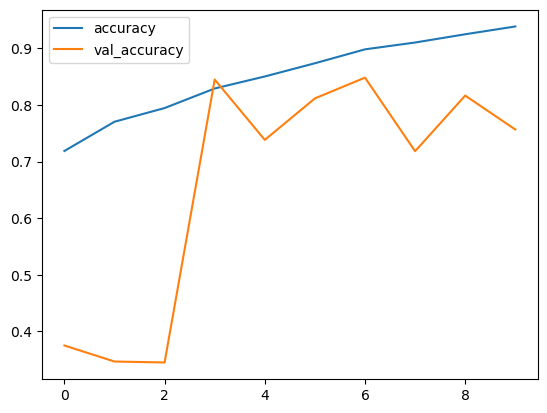

In [8]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Just like we thought, our validation accuracy is much lower than our training accuracy. But, it looks like it was starting to increase towards our later epochs. This likely means that if we increase the number of epochs for training, our performance will improve! If you want to test it, just update the EPOCHS variable a few blocks above, and rerun the training setup!

Now, we should evaluate our final model. All we need to do is run the final version of the model on our held out data and compare the predicted  classes to the actual classes! We can use a few different metrics for this:


1.   Precision: The proportion of images assigned to a given category that were actually part of that category
2.   Recall: The proportion of images that belong to a category that were properly assigned
3.   F1-score: A balanced measure of prediction performance, uses the formula $\frac{2 * \text{Precision}* \text{Recall}}{\text{Precision} + \text{Recall}}$
4.   Support: Total number of images in each class, expected to be ~200.



In [9]:
Y_pred = model.predict(X_val)
np_Y_val = np.argmax(Y_val, axis=1)
np_Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(np_Y_val, np_Y_pred,
                                    target_names=classes))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
              precision    recall  f1-score   support

      lung_n       0.93      0.99      0.96       207
    lung_aca       0.72      0.89      0.80       195
    lung_scc       0.95      0.66      0.78       198

    accuracy                           0.85       600
   macro avg       0.87      0.85      0.84       600
weighted avg       0.87      0.85      0.85       600



How would you evaluate our performance? Are there any types of images that performed significantly worse than the others?

#### Save and load model

In [12]:
# save file
# file_name = 'model_and_weights.keras'
# model.save(file_name)

In [13]:
# # load model
# import keras.saving
# loaded_model = keras.saving.load_model(file_name)

In [14]:
# test loaded_model
# Y_pred = loaded_model.predict(X_val)
# np_Y_val = np.argmax(Y_val, axis=1)
# np_Y_pred = np.argmax(Y_pred, axis=1)
# print(metrics.classification_report(np_Y_val, np_Y_pred,
#                                     target_names=classes))